<a href="https://colab.research.google.com/github/Hans-han/python_automated_task/blob/main/%E8%BD%AE%E5%8A%A8%E7%AD%96%E7%95%A51.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import time
import akshare as ak
import numpy as np
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker




# 新段落

In [ ]:
def calculate_etf_performance(etf_symbols, window, html_file=None):
    # 获取 ETF 历史数据
    etf_data = {}
    for symbol in etf_symbols:
        etf_df = ak.fund_etf_hist_em(symbol=symbol, period="daily", adjust="hfq",start_date="20230501")[["日期","收盘"]] \
                    .rename(columns={"日期":"date","收盘":f"{symbol}"}).set_index("date")
        etf_data[symbol] = etf_df

    # 合并数据
    data = pd.concat(list(etf_data.values()), axis=1).dropna().iloc[:]
    data.index = pd.to_datetime(data.index)

    # 计算每日涨跌幅和滚动收益率
    for symbol in etf_symbols:
        column_name = f"{symbol}"
        data[f"{column_name}_day_return"] = data[column_name].rolling(2).apply(lambda x:(x[-1]-x[0])/x[0])
        data[f"{column_name}_return"] = data[column_name].rolling(window=window).apply(lambda x: x[-1]/x[0])
        data[f"{column_name}_ma"] = data[column_name].rolling(window=window).mean()

    # 去掉缺失值
    data = data.dropna()

    data["signal"] = data[[f"{symbol}_return" for symbol in etf_symbols]].idxmax(axis=1).str.split("_").str[0]
    data["signal"] = data["signal"].shift(1)
    data = data.dropna()
    data["signal_return"] = (np.cumprod(data.apply(lambda row: row[f'{row["signal"]}_day_return'], axis=1) + 1) * 100)


    for symbol in etf_symbols:
        column_name = f"{symbol}_return"
        data[column_name] = (100/data[f"{symbol}"].values[0]) * data[f"{symbol}"]

    # 绘制曲线图
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.set_xlabel('Time')
    ax.set_ylabel('Return')

    for symbol in etf_symbols:
        column_name = f"{symbol}_return"
        ax.plot(data[column_name].index, data[column_name].values)

    ax.plot(data["signal_return"].index, data["signal_return"].values)
    ax.legend(etf_symbols + ["signal_return"])

    ax.xaxis.set_major_locator(ticker.MultipleLocator(500))

    # 计算策略表现指标
    result = {}
    for symbol in etf_symbols + ["signal",]:
        column_name = f"{symbol}_return"
        result[column_name] = []
        for stat in ["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"]:
            r = getattr(qs.stats, stat)(data[column_name])
            result[column_name].append(r)


    result = pd.DataFrame(result, index=["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"])

    # 计算最近动量最强的 ETF
    momentum = data[[f"{symbol}" for symbol in etf_symbols]].iloc[-1]
    momentum_rank = momentum.rank(ascending=False)
    momentum_rank = momentum_rank / momentum_rank.sum()
    momentum_rank = momentum_rank.sort_values(ascending=False)
    momentum_etf = momentum_rank.index[0]
    momentum_return = data[f"{momentum_etf}"].iloc[-1]

    # 打印最近动量最强的 ETF 和其收盘价
    print(f"最近动量最强的 ETF 是 {momentum_etf}，策略回报为 {momentum_return:.2f}")

    return result



最近动量最强的 ETF 是 512100，策略回报为 0.87


,510300_return,513600_return,588000_return,512100_return,signal_return
avg_return,-0.000281,-0.000193,-0.003226,-0.002055,-0.002016
volatility,0.125681,0.183395,0.167983,0.141446,0.168600
sharpe,-0.545260,-0.260335,-4.674999,-3.351500,-2.911196
max_drawdown,-0.069450,-0.103786,-0.171662,-0.118126,-0.114824
win_rate,0.421053,0.482759,0.368421,0.425926,0.350877


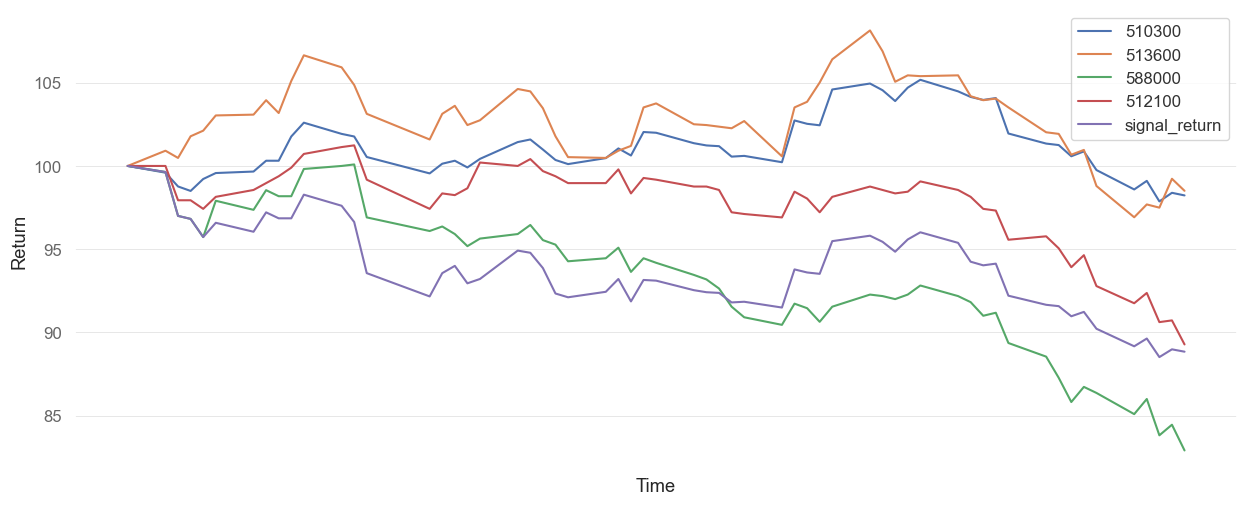

In [ ]:
# 构建轮动策略进行回测
etf_symbols = ["510300", "513600","588000","512100"]
window = 21
result = calculate_etf_performance(etf_symbols, window, "out.html")
display(result)